# Climate Analysis - Erick Hernandez

# Connect to DB and perform queries

In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from datetime import datetime

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import Column, Integer, String

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite", echo=True)

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

2020-12-02 21:16:54,061 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2020-12-02 21:16:54,068 INFO sqlalchemy.engine.base.Engine ()
2020-12-02 21:16:54,072 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2020-12-02 21:16:54,074 INFO sqlalchemy.engine.base.Engine ()
2020-12-02 21:16:54,078 INFO sqlalchemy.engine.base.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2020-12-02 21:16:54,080 INFO sqlalchemy.engine.base.Engine ()
2020-12-02 21:16:54,085 INFO sqlalchemy.engine.base.Engine PRAGMA main.table_xinfo("measurement")
2020-12-02 21:16:54,087 INFO sqlalchemy.engine.base.Engine ()
2020-12-02 21:16:54,092 INFO sqlalchemy.engine.base.Engine SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = 'measurement' AND type = 'table'
2020-12-02 21:16:54,094 INFO sqlalchemy.engine.base.Engine ()
2020-12-02 21:16:54,097 INFO sqlal

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measures = Base.classes.measurement
stations = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Exploring the columns of each table

from sqlalchemy import inspect
inspector = inspect(engine)
for table_name in inspector.get_table_names():
    print(f'Table: {table_name}')
    print("----------")
    for column in inspector.get_columns(table_name):
        print(column['name'])

2020-12-02 21:16:54,417 INFO sqlalchemy.engine.base.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2020-12-02 21:16:54,418 INFO sqlalchemy.engine.base.Engine ()
Table: measurement
----------
2020-12-02 21:16:54,421 INFO sqlalchemy.engine.base.Engine PRAGMA main.table_xinfo("measurement")
2020-12-02 21:16:54,421 INFO sqlalchemy.engine.base.Engine ()
id
station
date
prcp
tobs
Table: station
----------
2020-12-02 21:16:54,424 INFO sqlalchemy.engine.base.Engine PRAGMA main.table_xinfo("station")
2020-12-02 21:16:54,425 INFO sqlalchemy.engine.base.Engine ()
id
station
name
latitude
longitude
elevation


In [11]:
class MEAS(measures):
    __tablename__ = "measures_table"
    id = Column(Integer, primary_key=True)
    station = Column(String)
    date = Column(String)
    prcp = Column(Integer)
    tobs = Column(Integer)
    
class STAT(stations):
    __tablename__ = "stations_table"
    id = Column(Integer, primary_key=True)
    station = Column(String)
    name = Column(String)
    latitude = Column(Integer)
    longitude = Column(Integer)
    elevation = Column(Integer)

### Design a query to retrieve the last 12 months of precipitation data and plot the results

In [12]:
last_date = session.query(measures.date).order_by(measures.date.desc()).first()
last_date

2020-12-02 21:16:54,761 INFO sqlalchemy.engine.base.Engine BEGIN (implicit)
2020-12-02 21:16:54,765 INFO sqlalchemy.engine.base.Engine SELECT measurement.date AS measurement_date 
FROM measurement ORDER BY measurement.date DESC
 LIMIT ? OFFSET ?
2020-12-02 21:16:54,767 INFO sqlalchemy.engine.base.Engine (1, 0)


('2017-08-23')

In [13]:
type(last_date)

sqlalchemy.util._collections.result

In [14]:
last_date = str(last_date)
last_date = last_date.replace("'","")
last_date = last_date.replace("(","")
last_date = last_date.replace(")","")
last_date = last_date.replace(",","")

In [15]:
year, month, day = last_date.split('-')
year = int(year)
month = int(month)
day = int(day)

In [16]:
last_date = dt.date(year, month, day)

In [17]:
query_date = last_date - dt.timedelta(days=365)
query_date

datetime.date(2016, 8, 23)

In [18]:
session.query(measures.station, measures.prcp).filter(measures.date >= query_date).count()

2020-12-02 21:16:55,284 INFO sqlalchemy.engine.base.Engine SELECT count(*) AS count_1 
FROM (SELECT measurement.station AS measurement_station, measurement.prcp AS measurement_prcp 
FROM measurement 
WHERE measurement.date >= ?) AS anon_1
2020-12-02 21:16:55,285 INFO sqlalchemy.engine.base.Engine ('2016-08-23',)


2230

In [19]:
len(session.query(measures.station).all())

2020-12-02 21:16:55,357 INFO sqlalchemy.engine.base.Engine SELECT measurement.station AS measurement_station 
FROM measurement
2020-12-02 21:16:55,358 INFO sqlalchemy.engine.base.Engine ()


19550

In [20]:
statement = session.query(measures.station, measures.prcp).filter(measures.date >= query_date).all()
rain = pd.DataFrame(statement, columns=['Station', 'Precipitation'])
rain['Precipitation'] = rain['Precipitation'].fillna(0)
rain_for_plot = rain.groupby("Station")["Precipitation"].sum().to_frame().reset_index()
rain_for_plot

2020-12-02 21:16:55,461 INFO sqlalchemy.engine.base.Engine SELECT measurement.station AS measurement_station, measurement.prcp AS measurement_prcp 
FROM measurement 
WHERE measurement.date >= ?
2020-12-02 21:16:55,462 INFO sqlalchemy.engine.base.Engine ('2016-08-23',)


,Station,Precipitation
0,USC00513117,48.51
1,USC00514830,33.24
2,USC00516128,147.81
3,USC00517948,4.59
4,USC00519281,70.03
5,USC00519397,16.09
6,USC00519523,38.01


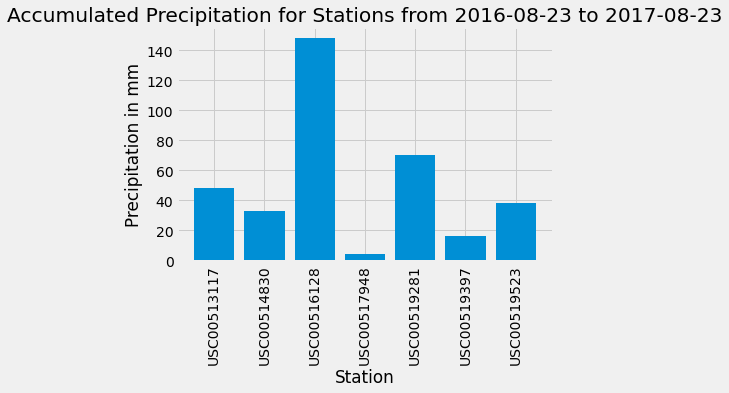

In [21]:
plt.bar(x=rain_for_plot["Station"], height=rain_for_plot["Precipitation"])
plt.xlabel("Station")
plt.ylabel("Precipitation in mm")
plt.xticks(rotation='vertical')
plt.title(f'Accumulated Precipitation for Stations from {query_date} to {last_date}')
plt.show()

### Calculate the date 1 year ago from the last data point in the database

In [22]:
last_date = session.query(measures.date).order_by(measures.date.desc()).first()
last_date

2020-12-02 21:16:55,833 INFO sqlalchemy.engine.base.Engine SELECT measurement.date AS measurement_date 
FROM measurement ORDER BY measurement.date DESC
 LIMIT ? OFFSET ?
2020-12-02 21:16:55,834 INFO sqlalchemy.engine.base.Engine (1, 0)


('2017-08-23')

In [23]:
type(last_date)

sqlalchemy.util._collections.result

In [24]:
last_date = str(last_date)
last_date = last_date.replace("'","")
last_date = last_date.replace("(","")
last_date = last_date.replace(")","")
last_date = last_date.replace(",","")

In [25]:
year, month, day = last_date.split('-')
year = int(year)
month = int(month)
day = int(day)

In [26]:
last_date = dt.date(year, month, day)

In [27]:
query_date = last_date - dt.timedelta(days=365)
query_date

datetime.date(2016, 8, 23)

### Perform a query to retrieve the data and precipitation scores

#### Save the query results as a Pandas DataFrame and set the index to the date column

Sort the dataframe by date

In [28]:
output = session.query(measures.id, measures.station, measures.date, measures.prcp, measures.tobs).all()
rain2 = pd.DataFrame(output, columns = ['id', 'station', 'date', 'prcp', 'tobs'])
rain2 = rain2.fillna(0)
rain2 = rain2.set_index('date')
rain2 = rain2.sort_index()
rain2

2020-12-02 21:16:56,366 INFO sqlalchemy.engine.base.Engine SELECT measurement.id AS measurement_id, measurement.station AS measurement_station, measurement.date AS measurement_date, measurement.prcp AS measurement_prcp, measurement.tobs AS measurement_tobs 
FROM measurement
2020-12-02 21:16:56,367 INFO sqlalchemy.engine.base.Engine ()


,id,station,prcp,tobs
date,,,,
2010-01-01,1,USC00519397,0.08,65.0
2010-01-01,9008,USC00518838,0.21,72.0
2010-01-01,9519,USC00519523,0.15,75.0
2010-01-01,12188,USC00519281,0.15,70.0
2010-01-01,14960,USC00511918,0.05,66.0
...,...,...,...,...
2017-08-22,19549,USC00516128,0.50,76.0
2017-08-23,2724,USC00519397,0.00,81.0
2017-08-23,7635,USC00514830,0.00,82.0


### Use Pandas Plotting with Matplotlib to plot the data

In [29]:
plott = rain2.groupby(rain2.index).mean()
plott = plott.drop(['id'], axis=1)
plott

,prcp,tobs
date,,
2010-01-01,0.151429,69.714286
2010-01-02,0.002857,67.000000
2010-01-03,0.000000,74.000000
2010-01-04,0.001429,75.000000
2010-01-05,0.005000,74.500000
...,...,...
2017-08-19,0.022500,78.750000
2017-08-20,0.003333,79.666667
2017-08-21,0.145000,79.500000


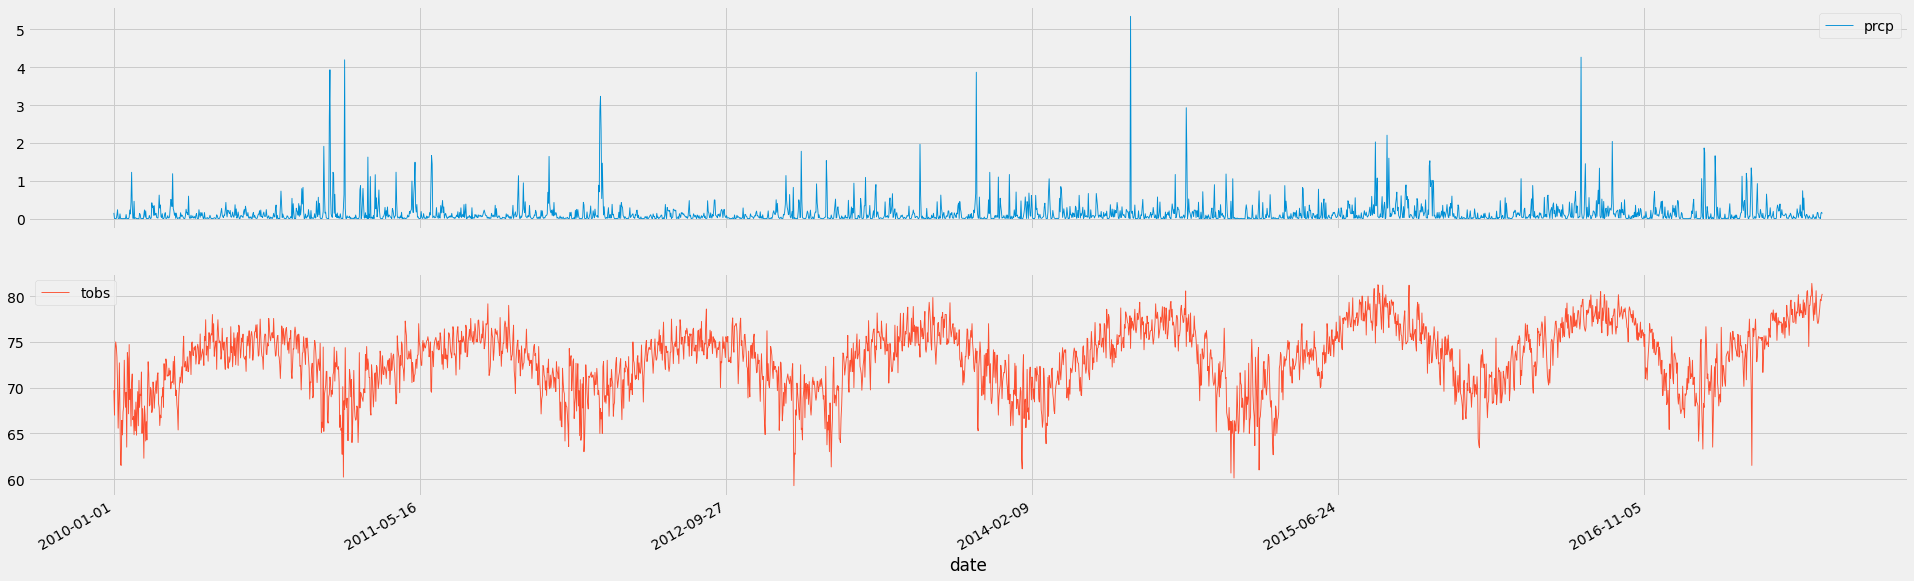

In [30]:
axes = plott.plot.line(figsize=(30,10), subplots=True, linewidth=0.9)

In [31]:
# Use Pandas to calcualte the summary statistics for the precipitation data
rain2[["prcp", "tobs"]].describe()

,prcp,tobs
count,19550.000000,19550.000000
mean,0.148753,73.097954
std,0.453021,4.523527
min,0.000000,53.000000
25%,0.000000,70.000000
50%,0.010000,73.000000
75%,0.090000,76.000000
max,11.530000,87.000000


In [32]:
# Design a query to show how many stations are available in this dataset?
session.query(stations.name).count()

2020-12-02 21:16:57,334 INFO sqlalchemy.engine.base.Engine SELECT count(*) AS count_1 
FROM (SELECT station.name AS station_name 
FROM station) AS anon_1
2020-12-02 21:16:57,334 INFO sqlalchemy.engine.base.Engine ()


9

In [33]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
counting = rain2.groupby("station")["id"].count().to_frame().reset_index()
counting = counting.set_index("station")
counting = counting.sort_values(axis=0,by=['id'], ascending=False)
counting

,id
station,
USC00519281,2772
USC00519397,2724
USC00513117,2709
USC00519523,2669
USC00516128,2612
USC00514830,2202
USC00511918,1979
USC00517948,1372
USC00518838,511


In [34]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?s
selected = rain2.loc[rain2["station"] == ""]
selected = selected.set_index("station")
print(f'The minimum temperature for station USC00519281 was of {selected["tobs"].min()}, the maximum of {selected["tobs"].max()}, while the average was of {round(selected["tobs"].mean(),1)} for the time observed')

The minimum temperature for station USC00519281 was of nan, the maximum of nan, while the average was of nan for the time observed


In [35]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
statement = session.query(measures.station, measures.prcp, measures.tobs).filter(measures.date >= query_date, measures.station == "USC00519281").all()
rain3 = pd.DataFrame(statement, columns=["station", "prcp", "tobs"])
rain3 = rain3.fillna(0)
rain3

2020-12-02 21:16:57,576 INFO sqlalchemy.engine.base.Engine SELECT measurement.station AS measurement_station, measurement.prcp AS measurement_prcp, measurement.tobs AS measurement_tobs 
FROM measurement 
WHERE measurement.date >= ? AND measurement.station = ?
2020-12-02 21:16:57,579 INFO sqlalchemy.engine.base.Engine ('2016-08-23', 'USC00519281')


,station,prcp,tobs
0,USC00519281,1.79,77.0
1,USC00519281,2.15,77.0
2,USC00519281,0.06,80.0
3,USC00519281,0.01,80.0
4,USC00519281,0.12,75.0
...,...,...,...
347,USC00519281,0.00,77.0
348,USC00519281,0.32,77.0
349,USC00519281,0.12,76.0
350,USC00519281,0.01,76.0


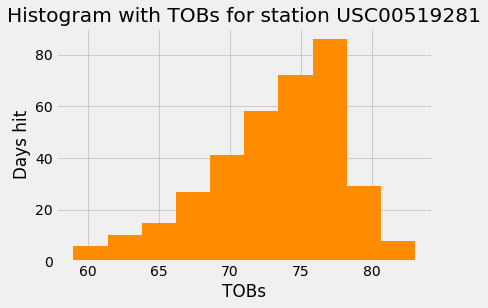

In [36]:
plt.hist(rain3['tobs'], color='darkorange')
plt.ylabel("Days hit")
plt.xlabel("TOBs")
plt.title("Histogram with TOBs for station USC00519281")
plt.show()

## Bonus Challenge Assignment

In [37]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measures.tobs), func.avg(measures.tobs), func.max(measures.tobs)).\
        filter(measures.date >= start_date).filter(measures.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

2020-12-02 21:16:57,820 INFO sqlalchemy.engine.base.Engine SELECT min(measurement.tobs) AS min_1, avg(measurement.tobs) AS avg_1, max(measurement.tobs) AS max_1 
FROM measurement 
WHERE measurement.date >= ? AND measurement.date <= ?
2020-12-02 21:16:57,821 INFO sqlalchemy.engine.base.Engine ('2012-02-28', '2012-03-05')
[(62.0, 69.57142857142857, 74.0)]


In [38]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

# my trip: 2017-06-02 to 2017-08-23

initial_date = '2017-06-02'
final_date = '2017-08-23'

my_temp = calc_temps(initial_date, final_date)

min, avg, max = my_temp[0]

2020-12-02 21:16:57,968 INFO sqlalchemy.engine.base.Engine SELECT min(measurement.tobs) AS min_1, avg(measurement.tobs) AS avg_1, max(measurement.tobs) AS max_1 
FROM measurement 
WHERE measurement.date >= ? AND measurement.date <= ?
2020-12-02 21:16:57,970 INFO sqlalchemy.engine.base.Engine ('2017-06-02', '2017-08-23')


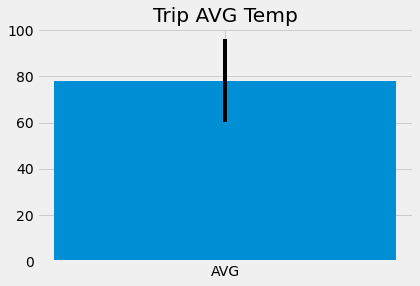

In [39]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

plt.bar(x="AVG", height=avg, yerr=max-min, width=0.1)
plt.title("Trip AVG Temp")
plt.show()


In [40]:
statement = session.query(stations.station, stations.name, stations.latitude, stations.longitude, stations.elevation).all()
Stations_DF = pd.DataFrame(statement, columns=['Station', 'Name', 'Latitude', 'Longitude', 'Elevation'])
Stations_DF

2020-12-02 21:16:58,244 INFO sqlalchemy.engine.base.Engine SELECT station.station AS station_station, station.name AS station_name, station.latitude AS station_latitude, station.longitude AS station_longitude, station.elevation AS station_elevation 
FROM station
2020-12-02 21:16:58,246 INFO sqlalchemy.engine.base.Engine ()


,Station,Name,Latitude,Longitude,Elevation
0,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
1,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
4,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
5,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
7,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
8,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4


In [41]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

statement = session.query(measures.station, measures.prcp, measures.tobs).filter(measures.date >= initial_date, measures.date < final_date).all()
rain4 = pd.DataFrame(statement, columns=["Station", "prcp", "tobs"])
rain4 = rain4.fillna(0)
rain4

2020-12-02 21:16:58,333 INFO sqlalchemy.engine.base.Engine SELECT measurement.station AS measurement_station, measurement.prcp AS measurement_prcp, measurement.tobs AS measurement_tobs 
FROM measurement 
WHERE measurement.date >= ? AND measurement.date < ?
2020-12-02 21:16:58,334 INFO sqlalchemy.engine.base.Engine ('2017-06-02', '2017-08-23')


,Station,prcp,tobs
0,USC00519397,0.00,79.0
1,USC00519397,0.02,79.0
2,USC00519397,0.00,79.0
3,USC00519397,0.00,80.0
4,USC00519397,0.00,79.0
...,...,...,...
461,USC00516128,0.00,76.0
462,USC00516128,0.09,71.0
463,USC00516128,0.00,78.0
464,USC00516128,0.56,76.0


In [42]:
merged_DF = pd.merge(left=rain4, right=Stations_DF)
merged_DF = merged_DF.sort_values(by=['prcp'], ascending=False)
merged_DF

,Station,prcp,tobs,Name,Latitude,Longitude,Elevation
435,USC00516128,4.00,72.0,"MANOA LYON ARBO 785.2, HI US",21.3331,-157.8025,152.4
431,USC00516128,2.40,77.0,"MANOA LYON ARBO 785.2, HI US",21.3331,-157.8025,152.4
398,USC00516128,1.69,77.0,"MANOA LYON ARBO 785.2, HI US",21.3331,-157.8025,152.4
181,USC00514830,1.19,79.0,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0
437,USC00516128,0.84,77.0,"MANOA LYON ARBO 785.2, HI US",21.3331,-157.8025,152.4
...,...,...,...,...,...,...,...
219,USC00517948,0.00,76.0,"PEARL CITY, HI US",21.3934,-157.9751,11.9
218,USC00517948,0.00,77.0,"PEARL CITY, HI US",21.3934,-157.9751,11.9
217,USC00517948,0.00,78.0,"PEARL CITY, HI US",21.3934,-157.9751,11.9
216,USC00517948,0.00,78.0,"PEARL CITY, HI US",21.3934,-157.9751,11.9


In [43]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measures.tobs), func.avg(measures.tobs), func.max(measures.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measures.date) == date).all()
    
daily_normals("01-01")

2020-12-02 21:16:58,529 INFO sqlalchemy.engine.base.Engine SELECT min(measurement.tobs) AS min_1, avg(measurement.tobs) AS avg_1, max(measurement.tobs) AS max_1 
FROM measurement 
WHERE strftime(?, measurement.date) = ?
2020-12-02 21:16:58,531 INFO sqlalchemy.engine.base.Engine ('%m-%d', '01-01')


[(62.0, 69.15384615384616, 77.0)]

In [44]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`


# Set the start and end date of the trip

# Use the start and end date to create a range of dates

my_days = ['01-01', '01-02', '01-03', '01-04', '01-05', '01-06', '01-07', '01-08']

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date

vacations = [daily_normals(x) for x in my_days]
vacations

2020-12-02 21:16:58,666 INFO sqlalchemy.engine.base.Engine SELECT min(measurement.tobs) AS min_1, avg(measurement.tobs) AS avg_1, max(measurement.tobs) AS max_1 
FROM measurement 
WHERE strftime(?, measurement.date) = ?
2020-12-02 21:16:58,667 INFO sqlalchemy.engine.base.Engine ('%m-%d', '01-01')
2020-12-02 21:16:58,682 INFO sqlalchemy.engine.base.Engine SELECT min(measurement.tobs) AS min_1, avg(measurement.tobs) AS avg_1, max(measurement.tobs) AS max_1 
FROM measurement 
WHERE strftime(?, measurement.date) = ?
2020-12-02 21:16:58,683 INFO sqlalchemy.engine.base.Engine ('%m-%d', '01-02')
2020-12-02 21:16:58,698 INFO sqlalchemy.engine.base.Engine SELECT min(measurement.tobs) AS min_1, avg(measurement.tobs) AS avg_1, max(measurement.tobs) AS max_1 
FROM measurement 
WHERE strftime(?, measurement.date) = ?
2020-12-02 21:16:58,699 INFO sqlalchemy.engine.base.Engine ('%m-%d', '01-03')
2020-12-02 21:16:58,714 INFO sqlalchemy.engine.base.Engine SELECT min(measurement.tobs) AS min_1, avg(meas

[[(62.0, 69.15384615384616, 77.0)],
 [(60.0, 69.39622641509433, 77.0)],
 [(62.0, 68.9090909090909, 77.0)],
 [(58.0, 70.0, 76.0)],
 [(56.0, 67.96428571428571, 76.0)],
 [(61.0, 68.96491228070175, 76.0)],
 [(57.0, 68.54385964912281, 76.0)],
 [(57.0, 67.16071428571429, 75.0)]]

In [45]:
minlist = []
maxlist = []
avglist = []

limits = len(vacations)
counting = np.arange(0,limits,1)

for x in counting:       
    min,avg,max = vacations[x][0]
    minlist.append(min)
    avglist.append(avg)
    maxlist.append(max)
    

In [46]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

my_dict = {'Dates': my_days,
          'Min Temp': minlist,
          'Avg Temp': avglist,
          'Max Temp': maxlist}

vacations_df = pd.DataFrame(my_dict)
vacations_df

,Dates,Min Temp,Avg Temp,Max Temp
0,01-01,62.0,69.153846,77.0
1,01-02,60.0,69.396226,77.0
2,01-03,62.0,68.909091,77.0
3,01-04,58.0,70.000000,76.0
4,01-05,56.0,67.964286,76.0
5,01-06,61.0,68.964912,76.0
6,01-07,57.0,68.543860,76.0
7,01-08,57.0,67.160714,75.0


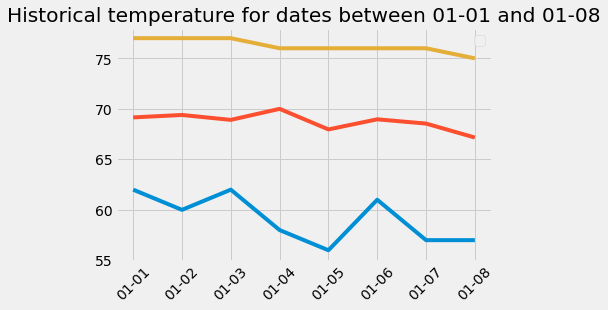

In [47]:
vacations_df.plot(kind="line", stacked=False)
plt.legend("")
plt.title(f'Historical temperature for dates between {my_days[0]} and {my_days[-1]}')
plt.xticks(range(0,len(my_days)),my_days, rotation=45)
plt.show()

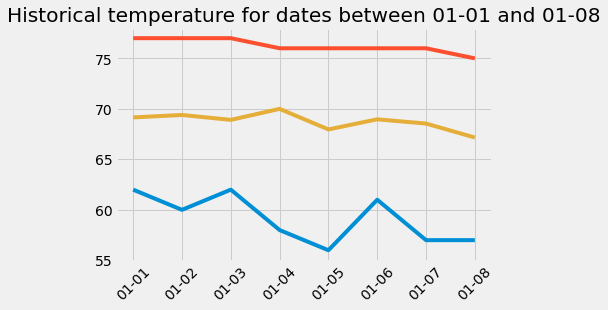

In [48]:
# Plot the daily normals as an area plot with `stacked=False`
plt.plot(my_days, minlist, label="min")
plt.plot(my_days, maxlist, label="max")
plt.plot(my_days, avglist, label="avg")
plt.title(f'Historical temperature for dates between {my_days[0]} and {my_days[-1]}')
plt.xticks(rotation=45)

plt.show()